# CUDA Spectrogram: Drew Schlesener and Denton Jarvis

## Environment Setup
These cells demonstrate how to create and activate the conda environment, install required packages, and prepare CUDA.
Run these commands in a terminal, not inside Jupyter.

In [38]:
!module load cuda anaconda3
!conda config --set solver libmamba
!conda env create -f env.yml
!conda activate spectrogram-cuda
!conda install ipykernel
!python -m ipykernel install --user --name spectrogram-cuda --display-name "Python (spectrogram-cuda)"
print("All steps executed, now select generated kernel as notebook kernel and proceed")

Channels:
 - conda-forge
 - defaults
Platform: linux-64
Solving environment: done

libcblas-3.9.0       | 17 KB     |                                       |   0% 
cuda-cudart-static_l | 1.1 MB    |                                       |   0% 

libcusparse-12.5.10. | 199.2 MB  |                                       |   0% 


libcublas-12.9.1.4   | 446.1 MB  |                                       |   0% 



click-8.3.1          | 90 KB     |                                       |   0% 




libcufft-11.4.1.4    | 154.6 MB  |                                       |   0% 





libopenblas-0.3.30   | 5.7 MB    |                                       |   0% 






cuda-cudart-dev_linu | 380 KB    |                                       |   0% 







cuda-version-12.9    | 21 KB     |                                       |   0% 








cuda-cudart_linux-64 | 193 KB    |                                       |   0% 









cupy-core-13.6.0     | 54.1 MB   |                            

In [39]:
!pip install cupy-cuda12x

# Imports
Load all required Python modules.

In [16]:
import numpy as np 
import cupy as cp 
print(cp.cuda.runtime.getDeviceCount())  # Should print 1
print(cp.__version__)
import soundfile as sf
import matplotlib.pyplot as plt
import time

print("Imports successful")

1
13.6.0
Imports successful


# Load WAV File

In [42]:
wav_path = "hype-drill-music-438398.wav" 
#wav_path = "test.wav" 
signal, sr = sf.read(wav_path)
if signal.ndim > 1:
    signal = np.mean(signal, axis=1)  # make audio file mono for easier processing
print(f"Loaded WAV: {signal.shape}, sample rate={sr}")

Loaded WAV: (11304576,), sample rate=48000


# Move audio buffer to GPU

In [43]:
# Setting Parameters
win_size = 1024
hop_size = 512
num_frames = (len(signal) - win_size) // hop_size # setting upperbound for range "grid"


# Audio framed for CPU / GPU
frames = np.stack([signal[i*hop_size:i*hop_size+win_size] for i in range(num_frames)]) # pack signal into a more compressed array based on hop size and win size
frames = np.hanning(win_size)[None, :] * frames #apply hanning function to remove discontinuities from signal for more efficient FFT

frames_gpu = cp.asarray(frames, dtype=cp.complex64) #convert frames into a complex64 array
print("Audio copied to GPU")

Audio copied to GPU


# Compute Spectrogram (CPU)
GPU FFT could be added later; this version ensures the spectrogram renders.

In [44]:
start_cpu = time.time()
# Convert to complex (CPU)
frames_cpu = frames.astype(np.complex64)

# Execute FFT on CPU
spec_cpu = np.fft.fft(frames_cpu, axis=1)

# Compute magnitude on CPU
spec = np.abs(spec_cpu)
cpu_time = time.time() - start_cpu
print("Spectrogram computed on CPU")



Spectrogram computed on CPU


# Compute Spectrogram (GPU)

In [45]:
start_event = cp.cuda.Event()
end_event = cp.cuda.Event()

start_event.record()
# Execute FFT on GPU
spec_gpu = cp.fft.fft(frames_gpu, axis=1)

# Compute magnitude on GPU
spec_magnitude = cp.abs(spec_gpu)

spec = cp.asnumpy(spec_magnitude) 
end_event.record()

end_event.synchronize()

elapsed_ms = cp.cuda.get_elapsed_time(start_event, end_event)
gpu_time = elapsed_ms / 1000.0
print("Spectrogram computed on GPU")

Spectrogram computed on GPU


# Plot Spectrogram CPU

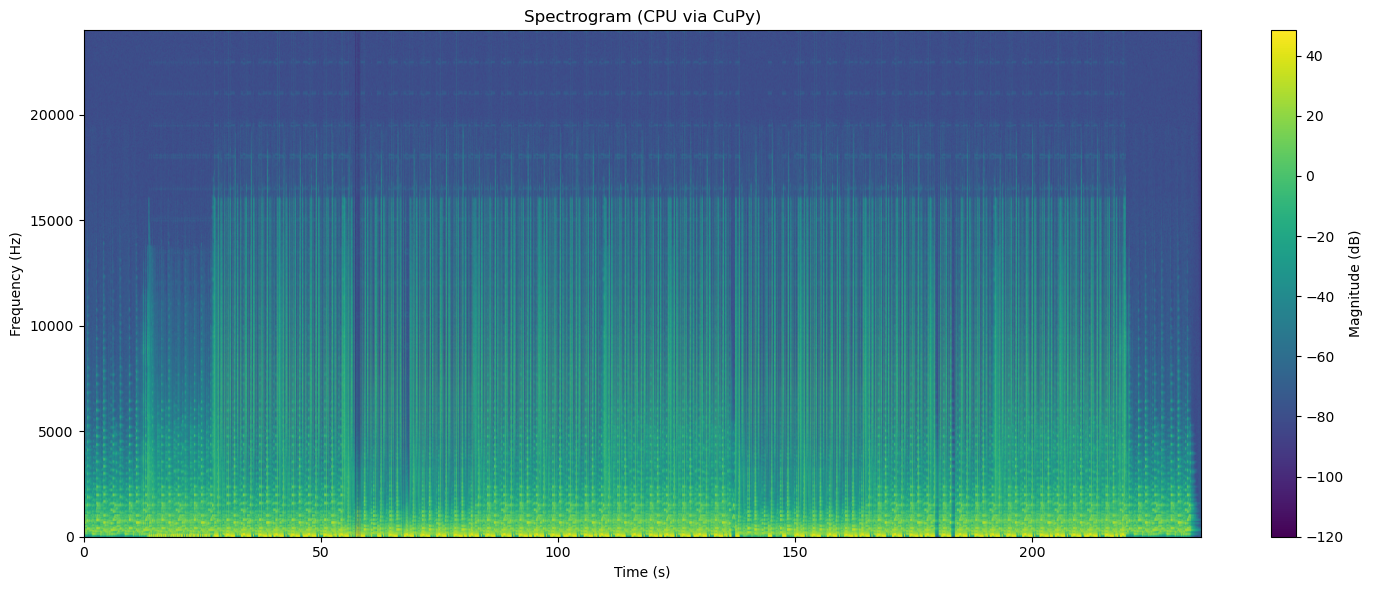

Audio duration: 235.51 seconds
Sample rate: 48000 Hz
Frequency resolution: 46.88 Hz per bin
Time resolution: 10.67 ms per frame


In [46]:
# Calculate time and frequency axes
duration = len(signal) / sr  # total duration in seconds
time_axis = np.linspace(0, duration, num_frames)
freq_axis = np.linspace(0, sr/2, win_size//2)

# Plot with proper axes
plt.figure(figsize=(15, 6))
plt.imshow(20 * np.log10(spec[:, :win_size//2].T + 1e-6), 
           origin="lower", 
           aspect="auto", 
           cmap="viridis",
           extent=[0, duration, 0, sr/2]) 
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.title("Spectrogram (CPU via CuPy)")
plt.colorbar(label="Magnitude (dB)")
plt.tight_layout()
plt.savefig('SpectrogramCPU.jpg', dpi=150)
plt.show()

print(f"Audio duration: {duration:.2f} seconds")
print(f"Sample rate: {sr} Hz")
print(f"Frequency resolution: {sr/win_size:.2f} Hz per bin")
print(f"Time resolution: {hop_size/sr*1000:.2f} ms per frame")

# Plot Spectrogram GPU

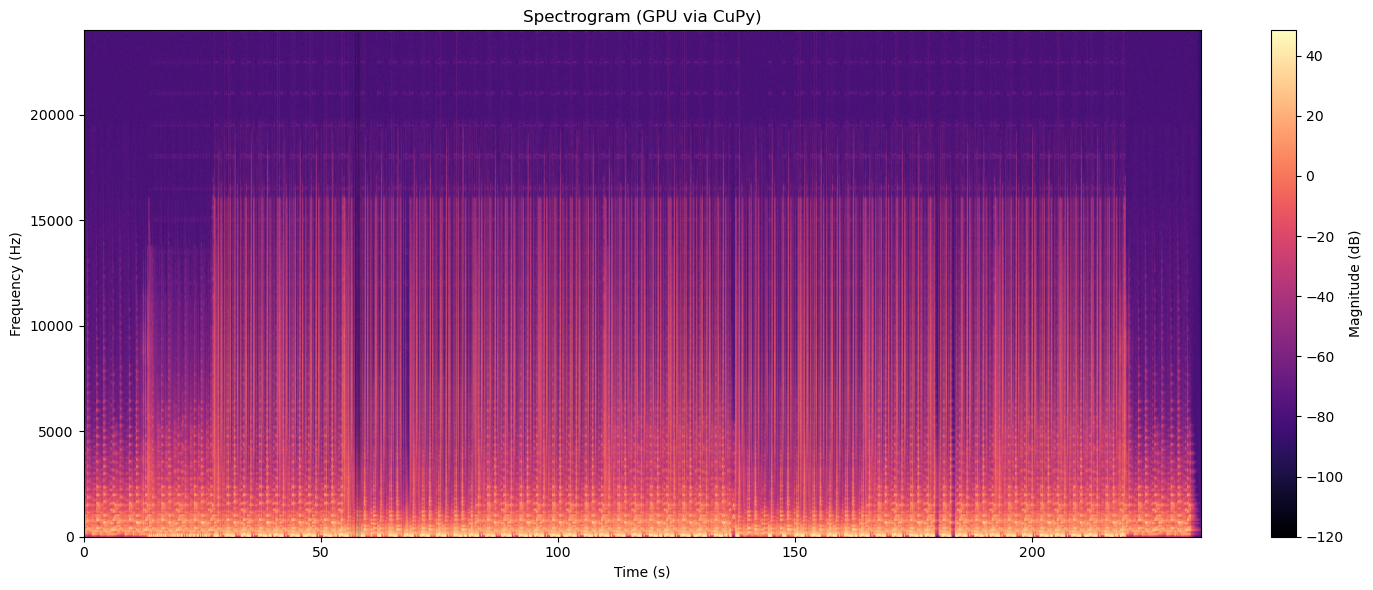

Audio duration: 235.51 seconds
Sample rate: 48000 Hz
Frequency resolution: 46.88 Hz per bin
Time resolution: 10.67 ms per frame


In [47]:
# Calculate time and frequency axes
duration = len(signal) / sr  # total duration in seconds
time_axis = np.linspace(0, duration, num_frames)
freq_axis = np.linspace(0, sr/2, win_size//2)

# Plot with proper axes
plt.figure(figsize=(15, 6))
plt.imshow(20 * np.log10(spec[:, :win_size//2].T + 1e-6), 
           origin="lower", 
           aspect="auto", 
           cmap="magma",
           extent=[0, duration, 0, sr/2]) 
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.title("Spectrogram (GPU via CuPy)")
plt.colorbar(label="Magnitude (dB)")
plt.tight_layout()
plt.savefig('SpectrogramGPU.jpg', dpi=150)
plt.show()

print(f"Audio duration: {duration:.2f} seconds")
print(f"Sample rate: {sr} Hz")
print(f"Frequency resolution: {sr/win_size:.2f} Hz per bin")
print(f"Time resolution: {hop_size/sr*1000:.2f} ms per frame")

In [48]:
print(f"CPU time: {cpu_time:.4f}s")
print(f"GPU time: {gpu_time:.4f}s")
print(f"Speedup: {cpu_time/gpu_time:.2f}x")

CPU time: 0.3454s
GPU time: 0.0321s
Speedup: 10.77x
